In [1]:
from inspect import getmembers, isfunction

import tenseal 
print(getmembers(tenseal, isfunction))

[('bfv_tensor', <function bfv_tensor at 0x7f04f92f0790>), ('bfv_tensor_from', <function bfv_tensor_from at 0x7f04f92f0820>), ('bfv_vector', <function bfv_vector at 0x7f04f92f0280>), ('bfv_vector_from', <function bfv_vector_from at 0x7f04f92f0310>), ('ckks_tensor', <function ckks_tensor at 0x7f04f92f05e0>), ('ckks_tensor_from', <function ckks_tensor_from at 0x7f04f92f0670>), ('ckks_vector', <function ckks_vector at 0x7f04f92f0430>), ('ckks_vector_from', <function ckks_vector_from at 0x7f04f92f04c0>), ('context', <function context at 0x7f04f92f0040>), ('context_from', <function context_from at 0x7f04f92f00d0>), ('enc_matmul_encoding', <function enc_matmul_encoding at 0x7f04f9344f70>), ('im2col_encoding', <function im2col_encoding at 0x7f0510582b80>), ('lazy_bfv_tensor_from', <function lazy_bfv_tensor_from at 0x7f04f92f08b0>), ('lazy_bfv_vector_from', <function lazy_bfv_vector_from at 0x7f04f92f03a0>), ('lazy_ckks_tensor_from', <function lazy_ckks_tensor_from at 0x7f04f92f0700>), ('lazy_c

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tenseal as ts

In [7]:
context = ts.context(
            ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=32768,
            coeff_mod_bit_sizes=[60, 40, 40, 60]
          )

context.generate_galois_keys()
context.global_scale = 2**40

def newton_method_div_init(a, number_iters = 73):
    number = np.finfo(float).eps # number to get inverse of
    for i in range(number_iters): # iteration number
        number = number*(2-a*number) # update
        #print(i,number)
    return number

def gold_div(a,b,iter = 1):
    r = 1/b
    #r = #newton_method_div_init(b,40)
    #print(a,b)
    for i in range(0,iter):
        a = r*a
        b = r*b
        r = 2 + -1*b
    return a 

def newton_method_sq(number, number_iters=2):
    a = number # number to get square root of
    for i in range(number_iters): # iteration number
        number = 0.5 *(number+gold_div(a,number))
        #number = 0.5 * (number+a/number)
    #print("sqrt of:",a,"is =", number)
    return number

def pow_summa(x):
    sum = 0 
    for i in range(0,len(x)):
       sum = sum + x[i]*x[i]
    #print("pow_sum of",x,"is =",sum)
    return sum

def norm(v):
    #print("pow_sum =",pow_summa(v))
    v_norm = newton_method_sq(pow_summa(v))
    #print("norm of v is =",v_norm)
    return v_norm




def gold_square(s, iterations = 10):
    #y = np_invsqrt(s)
    y = gold_div(1,newton_method_sq(s,10))
    x = s*y
    h = y*0.5
    for i in range(0,iterations):
        r = 0.5-x*h
        x = x + x*r
        h = h + h*r
    return x, 2*h

def pow_eig_comb(a,iterations = 5):
    a_len = len(a)
    Big_lamb = np.zeros(a_len)
    Big_w = np.zeros((a_len,a_len)) #vector is the size of the initial matrix
    for i in range(0,a_len):
        #x = np.random.rand(a_len,1)     #random initial vector
        x = np.ones((a_len,1)) 
        #print(x)
        w = gold_div(x,np.linalg.norm(x))      #scaled random initial vector
        #x/np.linalg.norm(x)          
        for j in range(0,iterations):
            x = np.dot(a,w)                #expensive would be nice if replaceable
            lambda_new = np.linalg.norm(x) #can't do this on encrypted data but good enough for now (need goldschmidt)
            w = gold_div(x,lambda_new)
            #x / lambda_new             #need gold_div
            if j+2 == iterations:
                w_old = w[0]
        #print(i,"here")
        div = w[0]/w_old #gold_div(w[0],w_old)     #used to check if eigenvalue is negative 
        lambda_new = div*lambda_new     
        w = div*w
        Big_lamb[i] = lambda_new          #storing eigenval and vectors in their separate matrices
        Big_w[i] = w.T
        a = a+-1*lambda_new*w*w.T
    return Big_lamb, Big_w

def summa(x):
    x_len = len(x)
    sum = 0 
    for i in range(0,x_len):
        sum = sum + x[i]
    return sum

def dist_metric(p,q):
    p = np.asarray(p).flatten()
    q = np.asarray (q).flatten()
    sum1 = np.sum((p+-1*q)*(p+-1*q))
    #summa((p+-1*q)*(p+-1*q))
    sq1 = newton_method_sq(sum1,2)
    return sq1

def predict (W, mu , projections, y, X):
    minDist = float("inf")
    minClass = -1
    Q = project (W, X.reshape (1 , -1) , mu)
    for i in range (len(projections)):
        dist = dist_metric( projections[i], Q)
        if dist < minDist:
            minDist = dist
            minClass = i
    return minClass

In [8]:
v1 = np.array([0, 1, 2, 3, 4])
#m1 = [[0,1,2,3,4],[0,1,2,3,4]]
v2 = [4, 3, 2, 1, 0]
sum_test = [1,1,1,1,1]
#enc_tns1 = ts.ckks_tensor(context, v1)
#enc_tns2 = ts.ckks_tensor(context, sum_test)
#result = enc_tns1 * enc_tns2
#print("Plain equivalent: {} * {}\nDecrypted result: {}.".format(v1, sum_test, result.decrypt()))
#encrypted vectors

def gold_div_vec(a,b,iter = 10): #divide vectors
    sum = 0
    for i in range(0,len(a)):
        sum = sum + gold_div(a[i],b[i],iter)
    return sum

def vec_mult(v1,v2):
    n = len(v1)
    #print("v2_size =",np.size(v2))
    #print(n,len(v2))
    v_mult = []
    for i in range(0,n): 
        v_mult.append(v1[i]*v2[i])
    return np.sum(v_mult)

#function for encrypting every element in a vector as an encrypted vector:
def enc_vec(v1):
    enc_v1 = []
    vv1 = []
    for i in range(0,len(v1)):
        vv1 = [v1[i]]
        enc_v1.append(ts.ckks_vector(context,vv1))
    return(np.array(enc_v1))

#function for decrypting every element in a vector:
def dec_vec(v1):
    dec_v1 = []
    vv1 = []
    for i in range(0,len(v1)):
        vv1 = v1[i].decrypt()               #decrypts a "vector element" which is just an element formed as a vector for encryption purposes
        dec_v1.append(vv1[0])               
    return(dec_v1)

#print(np.size(v1))

#def mean_vec(v1):
 #   sum = summa(v1)
 #   mean = sum* newton_method_div_init(len(v1),80)
 #   return mean


enc_v1 = enc_vec(v1)
enc_v2 = enc_vec(v2)
#print(enc_v1)
dec_v1 = dec_vec(enc_v1)
#print(dec_v1)

#print("sum_v1 =",summa(enc_v1).decrypt())
#mean_v1 = mean_vec(enc_v1)
#print(mean_v1.decrypt())

def enc_pictures(X2):
    #making the encrypted pictures by first reverting them to a less dimension turning each picture into a 1D vector
    enc_pics = []
    for i in range(0,len(X2)):  
        enc_pic = enc_vec(X2[i])                #encrypting the vectors using tenseal with built in function ckks_vector
        enc_pics.append(enc_pic)                #We then store all the encrypted pictures in
    return enc_pics

def dec_pictures(X):
    dec_pics = []
    vv1 = []
    for i in range(0,len(X)):
        dec_pic = dec_vec(X[i])
        dec_pics.append(dec_pic)
    return(dec_pics)

#mean_v1 = mean_vec(enc_v1)
#print(mean_vec.decrypt())
#enc_v1 = ts.ckks_vector(context, v1)
#summ = ts.ckks_vector(context, sum_test)
#a = enc_v1 * summ
#print(a.decrypt())

#summa(enc_v1,4)
#enc_m1 = ts.ckks_vector(context, m1)
#enc_v1 = ts.ckks_vector(context,v1)
#enc_v2 = ts.ckks_vector(context, v2)
#enc_sum = ts.ckks_vector(context, sum_test)
#result = enc_v1.dot(enc_v2)

#print(result.decrypt())
#print(dist_metric(enc_v1,enc_v2))
#print(enc_m1)
#result = enc_v1 + enc_v2
#print(result.decrypt())
#result = dist_metric(enc_v1,enc_v2)
#print(result)
#print(result.decrypt()) # ~ [4, 4, 4, 4, 4]

#result = enc_v1.dot(enc_v2)
#result.decrypt()

#encrypting all the elements of a vector 
#print(np.linalg.norm(v1))
#vector_test = enc_v1

#e = enc_v1[2]*enc_v2[2]

#print("e =",e.decrypt())

def vec_dot(v1,v2):
    n = len(v1)
    m = len(v2)
    #print(m,n)
    v_mat = [[]]*m          #making an empty "matrix" of size m
    #print(np.shape(v1))
    #print(np.shape(v2))
    for i in range(0,m):
        v_mult = []         #initialize the inner matrix which need to be reinitialized each time because ckks vectors are an annoyance
        for j in range(0,n): 
            v_mult.append(v1[i]*v2[j]) #appending is done here since that is the only acceptable thing for a ckks vector for some reason
        v_mat[i] = v_mult   #putting the size n vector into the ith slot of the size m "matrix"
    return v_mat


q = vec_mult(enc_v1,enc_v2)
#print(q.decrypt())
w = np.dot(v1,v2)
#print(w)
#print(w)
#print(q.decrypt())
#print(enc_v1)
#print(len(enc_v1),len(v2))

e = vec_dot(enc_v1,enc_v2)
dec_e = dec_pictures(e)
#print(dec_e)
#print(np.shape(dec_e))

#summa = np.sum(enc_v1)
#print(summa.decrypt())
#enc_v1_2 = ts.ckks_vector(context,v1)
#print(enc_v1_2.__sizeof__())
#print(ts.ckks_vector.data())

#print(enc_v1_2.load(context))

#print(np.dot(enc_v1,enc_v2).decrypt())
#print(v2)
#print(np.argsort(- np.array(enc_v2)).decrypt())

In [20]:
def matrix_mult(m1,m2):
    r1 = len(m1)         #mxn 
    r2 = len(m2)      #nxk
    c2 = len(m2[0])
    mul2 = np.zeros((r1,c2))
    for i in range(0,r1):
        for j in range(0,c2):
            for k in range(0,r2):
                mul2[i][j] = mul2[i][j] + m1[i][k]*m2[k][j]
    return mul2
def matrix_mult(m1,m2):
    r1 = len(m1)         #mxn 
    r2 = len(m2)      #nxk
    c2 = len(m2[0])
    #mul = [[]]*r1                    #r1xc2 = mxk
    mul3 = []
    #mul2 = np.zeros((r1,c2))
    for i in range(0,r1):
        m_mult = []
        for j in range(0,c2):
            m_mult2 = []
            for k in range(0,r2):
                #m1[0][0]*m2[0][0]
                #print(m1[0][0].decrypt())
                #mul2[i][j] = mul2[i][j] + m1[i][k]*m2[k][j]
                m_mult2.append(m1[i][k]*m2[k][j])
            #print(dec_vec(m_mult2))
            m_mult.append(np.sum(m_mult2))
        mul3.append(m_mult)
        #mul[i] = m_mult
        #print(mul2)
    return mul3

def transpose(matrix):
    rows = len(matrix)
    columns = len(matrix[0])

    matrix_T = []
    for j in range(columns):
        row = []
        for i in range(rows):
           row.append(matrix[i][j])
        matrix_T.append(row)

    return matrix_T    

matrix = np.array([
  [73, 0.5, 8],
  [81, -5, 66],
  [-100, -78, -2],
  [0, 9, 17],
  [69, 11 , 10],
])

enc_mat = np.array(enc_pictures(matrix))
#print(transpose(dec_pictures(enc_mat)))
#print(matrix)
qwert = np.dot(enc_mat.T,enc_mat)
#print(dec_pictures(qwert))
#print(np.dot(matrix.T,matrix))
#print(dec_pictures(matrix_mult(transpose(enc_mat),enc_mat)))
enc_mat2 = ts.ckks_vector(context,matrix[0])
#ts.ckks_vector(context,matrix)
print(enc_mat2)
print(enc_mat2.__getattribute__(len(enc_mat2)-1))
#print(matrix.reshape(1 , -1))

AttributeError: 'CKKSVector' object has no attribute '__getitem__'

# Eigenfaces: Survey and Implementation from Scratch
## Author: Svetlana Topalova

### Abstract
Eigenfaces method is used for face recognition. The problem with the image representation we are given is its high dimensionality. The question is: Are all dimensions equally useful for us? We can only make a decision if there’s any variance in data, so what we are looking for are the components that account for most of the information. The Principal Component Analysis (PCA) turn a set of possibly correlated variables into a smaller set of uncorrelated variables. The idea is, that a high-dimensional dataset is often described by correlated variables and therefore only a few meaningful dimensions account for most of the information. The PCA method finds the directions with the greatest variance in the data, called principal components. In the recognition process, an eigenface is formed for the given face image, and the Euclidian distances between this eigenface and the previously stored eigenfaces are calculated. The eigenface with the smallest Euclidian distance is the one the person resembles the most.

## Eigenfaces
**Eigenfaces** is the name given to a set of **eigenvectors** when they are used in the computer vision problem of human face recognition. The approach of using eigenfaces for recognition was developed by Sirovich and Kirby (1987) and used by Matthew Turk and Alex Pentland in face classification. The eigenvectors are derived from the covariance matrix of the probability distribution over the high-dimensional vector space of face images. The eigenfaces themselves form a basis set of all images used to construct the covariance matrix. This produces dimension reduction by allowing the smaller set of basis images to represent the original training images. Classification can be achieved by comparing how faces are represented by the basis set.

Eigenfaces refers to an appearance-based approach to face recognition that seeks to capture the variation in a collection of face images and use this information to encode and compare images of individual faces in a holistic (as opposed to a parts-based or feature-based) manner. Specifically, the eigenfaces are the principal components of a distribution of faces, or equivalently, the eigenvectors of the covariance matrix of the set of face images, where an image with N pixels is considered a point (or vector) in N-dimensional space. The idea of using principal components to represent human faces was developed by Sirovich and Kirby (Sirovich and Kirby 1987) and used by Turk and Pentland (Turk and Pentland 1991) for face detection and recognition. The Eigenface approach is considered by many to be the first working facial recognition technology, and it served as the basis for one of the top commercial face recognition technology products. Since its initial development and publication, there have been many extensions to the original method and many new developments in automatic face recognition systems. Eigenfaces is still often considered as a baseline comparison method to demonstrate the minimum expected performance of such a system.

The motivation of Eigenfaces is twofold:

* Extract the relevant facial information, which may or may not be directly related to human intuition of face features such as the eyes, nose, and lips. One way to do so is to capture the statistical variation between face images.
* Represent face images efficiently. To reduce the computation and space complexity, each face image can be represented using a small number of parameters.

The eigenfaces may be considered as a set of features which characterize the global variation among face images. Then each face image is approximated using a subset of the eigenfaces, those associated with the largest eigenvalues. These features account for the most variance in the training set.[1]

A set of eigenfaces can be generated by performing a mathematical process called principal component analysis (PCA) on a large set of images depicting different human faces. Informally, eigenfaces can be considered a set of "standardized face ingredients", derived from statistical analysis of many pictures of faces. Any human face can be considered to be a combination of these standard faces. For example, one's face might be composed of the average face plus 10% from eigenface 1, 55% from eigenface 2, and even -3% from eigenface 3. Remarkably, it does not take many eigenfaces combined together to achieve a fair approximation of most faces. Also, because a person's face is not recorded by a digital photograph, but instead as just a list of values (one value for each eigenface in the database used), much less space is taken for each person's face.[2]
### Eigenvalues and eigenvectors
In linear algebra, an eigenvector or characteristic vector of a linear transformation is a non-zero vector that only changes by a scalar factor when that linear transformation is applied to it. More formally, if $ T $ is a linear transformation from a vector space V over a field F into itself and v is a vector in V that is not the zero vector, then v is an eigenvector of $ T $ if $ {T}(v) $ is a scalar multiple of $ v $. This condition can be written as the equation

$$ {T}(v) = \lambda v $$
where $ \lambda  $ is a scalar in the field $ F $, known as the eigenvalue, characteristic value, or characteristic root associated with the eigenvector $ v $.

If the vector space $ V $ is finite-dimensional, then the linear transformation $ T $ can be represented as a square matrix $ A $, and the vector $ v $ by a column vector, rendering the above mapping as a matrix multiplication on the left hand side and a scaling of the column vector on the right hand side in the equation

$$ Av = \lambda v $$
There is a correspondence between n by n square matrices and linear transformations from an n-dimensional vector space to itself. For this reason, it is equivalent to define eigenvalues and eigenvectors using either the language of matrices or the language of linear transformations.

Eigenvalues and eigenvectors give rise to many closely related mathematical concepts:
* The set of all eigenvectors of a linear transformation, each paired with its corresponding eigenvalue, is called the eigensystem of that transformation.
* The set of all eigenvectors of T corresponding to the same eigenvalue, together with the zero vector, is called an eigenspace or characteristic space of T.
* If the set of eigenvectors of T form a basis of the domain of T, then this basis is called an eigenbasis.[3]

### PCA
Principal component analysis (PCA) was invented in 1901 by Karl Pearson. PCA is a statistical procedure that uses an **orthogonal transformation** to convert a set of observations of possibly correlated variables into a **set of values of linearly uncorrelated variables called principal components**. If there are ${\displaystyle n}$ n observations with ${\displaystyle p}$ p variables, then the number of distinct principal components is ${\displaystyle \min(n-1,p)}$ . This transformation is defined in such a way that the **first principal component has the largest possible variance** (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors are an uncorrelated orthogonal basis set. PCA is sensitive to the relative scaling of the original variables.

PCA is mostly used as a tool in **exploratory data analysis and for making predictive models**. It's often used to visualize genetic distance and relatedness between populations. PCA can be done by eigenvalue decomposition of a data covariance (or correlation) matrix or singular value decomposition of a data matrix, usually after mean centering (and normalizing or using Z-scores) the data matrix for each attribute. The results of a PCA are usually discussed in terms of component scores, sometimes called factor scores (the transformed variable values corresponding to a particular data point), and loadings (the weight by which each standardized original variable should be multiplied to get the component score).

PCA is **the simplest of the true eigenvector-based multivariate analyses**. Often, its operation can be thought of as **revealing the internal structure of the data in a way that best explains the variance** in the data. If a multivariate dataset is visualised as a set of coordinates in a high-dimensional data space (1 axis per variable), PCA can supply the user with a lower-dimensional picture, a projection of this object when viewed from its most informative viewpoint. This is done by **using only the first few principal components** so that the **dimensionality** of the transformed data is **reduced**.[4]

### Calculate EigenFaces
The pictures constituting the training set should have been taken under the same lighting conditions, and must be normalized to have the eyes and mouths aligned across all images. They must also be all resampled to a common pixel resolution (r × c). 
The images in the given training set have resolution 250x250.
#### 1. Read Images 
Obtaining face images ${\displaystyle I_{1}, I_{2}, ..., I_{n}}$ (training faces)
We read all images in the specified directory using the function **read_images**. 
Images are divided by subcategories which are the names of the persons. These names will keep in separate array as a reference between the image and the person's name. Used images are downloaded from [http://vis-www.cs.umass.edu/lfw/]

In [10]:
IMAGE_DIR = 'training-images'
DEFAULT_SIZE = [2, 2] 

def read_images(image_path=IMAGE_DIR, default_size=DEFAULT_SIZE):
    images = []
    images_names = []
    image_dirs = [image for image in os.listdir(image_path) if not image.startswith('.')]
    for image_dir in image_dirs:
        dir_path = os.path.join(image_path, image_dir)
        image_names = [image for image in os.listdir(dir_path) if not image.startswith('.')]
        for image_name in image_names:
            image = Image.open (os.path.join(dir_path, image_name))
            image = image.convert ("L")
            # resize to given size (if given )
            if (default_size is not None ):
                image = image.resize (default_size , Image.ANTIALIAS )
            images.append(np.asarray (image , dtype =np. uint8 ))
            images_names.append(image_dir)
    return [images,images_names]

#### 2. Assemble Data Matrix
Represent every image $ {I_{i}} $ as a vector G, where G is an $1x(rc)$ vector, corresponding to an **r × c** face image  $ {I_{i}} $. 

<img src="image_vector.png" />
See [8]

We use the function **as_row_matrix** to assemble the images into a data matrix. **Each row** of the data matrix is **one image**.

In [11]:
def as_row_matrix (X):
    if len (X) == 0:
        return np. array ([])
    mat = np. empty ((0 , np.size(X [0]) ), dtype =X [0]. dtype )
    for row in X:
        mat = np.vstack(( mat , np.asarray( row ).reshape(1 , -1))) # 1 x r*c 
    #enc_mat = ts.ckks_vector(context, mat)
    return mat

#### 3. Compute the mean face $\mu$. 

The mean vector consists of the means of each variable and the variance-covariance matrix consists of the variances of the variables along the main diagonal and the covariances between each pair of variables in the other matrix positions.
[9]

The average of the image set is calculated as:
<img src="mean_face_formula.png" />
See [7]

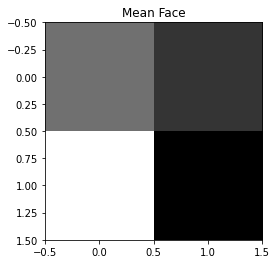

In [12]:
def enc_pictures(X2):
    #making the encrypted pictures by first reverting them to a less dimension turning each picture into a 1D vector
    enc_pics = []
    for i in range(0,len(X2)):  
        enc_pic = enc_vec(X2[i])                #encrypting the vectors using tenseal with built in function ckks_vector
        enc_pics.append(enc_pic)                #We then store all the encrypted pictures in
    return enc_pics

def dec_pictures(X):
    dec_pics = []
    for i in range(0,len(X)):
        dec_pic = dec_vec(X[i])
        dec_pics.append(dec_pic)
    return(dec_pics)


[X, y] = read_images()      #images, imgae_name
X2 = as_row_matrix(X)

enc_pics = enc_pictures(X2)

average_weight_matrix = np.reshape(as_row_matrix(X).mean(axis=0), X[0].shape)
plt.imshow(average_weight_matrix, cmap=plt.cm.gray)
plt.title("Mean Face")
plt.show()

[110.98129083620489, 108.71713665609208, 116.37752496565554, 106.71713378708533]


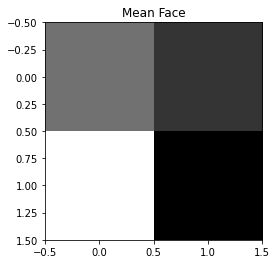

In [13]:
def row_summa(x):
    sum = np.zeros(len(x[0]))
    for j in range(len(x)):#2500
        sum = sum + x[j]
    return sum

def mean_vec(v1):
    mean = [] 
    sum = np.sum(v1,axis=0) #row_summa(v1) # 
    div = gold_div(1,len(v1)) #
    for i in range(len(v1[0])):
        mean.append(sum[i]*div)
    return mean

mu = mean_vec(enc_pics)  #this is the equivalent of as_row_matrix(X).mean(axis=0)
#print(dec_vec(np.sum(enc_pics,axis=0)))

#print(X2.mean(axis=0))
#print(X2)
#print(mean_vec(X2))
print(dec_vec(mu))
average_weight_matrix2 = np.reshape(dec_vec(mu), X[0].shape)
plt.imshow(average_weight_matrix2, cmap=plt.cm.gray)
plt.title("Mean Face")
plt.show()

#### 4. Calculate PCA :
We define function **pca** to calculate it in the following steps:
##### Step 1. Subtract the mean. The average image a has to be subtracted from each original image in X.
    
##### Step 2. Calculate the eigenvectors and eigenvalues of the covariance matrix S. 
In probability theory and statistics, a covariance matrix (also known as dispersion matrix or variance–covariance matrix) is a matrix whose element in the i, j position is the covariance between the i-th and j-th elements of a random vector. A random vector is a random variable with multiple dimensions. Each element of the vector is a scalar random variable. Each element has either a finite number of observed empirical values or a finite or infinite number of potential values. The potential values are specified by a theoretical joint probability distribution.
Compute the the Covariance Matrix S
<img src="covariance _matrix.png" />
            See [7]

Compute the eigenvalues $\lambda_{i}$ and eigenvectors $v_{i}$ of S
<img src="eigenvalues.png" />
            See [7]
            
Each eigenvector has the same dimensionality (number of components) as the original images, and thus can itself be seen as an image. The eigenvectors of this covariance matrix are therefore called eigenfaces. They are the directions in which the images differ from the mean image. Usually this will be a computationally expensive step (if at all possible), but the practical applicability of eigenfaces stems from the possibility to compute the eigenvectors of S efficiently, without ever computing S explicitly, as detailed below.

##### Step 3. Choose the principal components. 
Sorting the eigenvalues with np.argsort in descending order and arrange eigenvectors accordingly. The number of principal components k is determined arbitrarily by setting a threshold ε on the total variance. Total variance ${\displaystyle v=n\cdot (\lambda _{1}+\lambda _{2}+...+\lambda _{n})}$, n = number of data images by
k is the smallest number satisfies : ${\displaystyle {\frac {n(\lambda _{1}+\lambda _{2}+...+\lambda _{k})}{v}}>\epsilon } $ 
We calculate it with function **get_number_of_components_to_preserve_variance** for variance=0.95.
<img src="select_eigenfaces.png" />
See [6]

The k principal components of the observed vector x are then given by:

$y = W^{T} (x - \mu)$

where $W = (v_{1}, v_{2}, \ldots, v_{k})$. 

See [7]

In [14]:
#def vec_dot(v1,v2):
#    #print(np.matmul(v1,v2))
#    n = len(v1)
#    m = len(v2)
#    print(np.shape(v1))
#    v_mat = [[]]*m          #making an empty "matrix" of size m
#    for i in range(0,m): 
#        v_mult = []         #initialize the inner matrix which need to be reinitialized each time because ckks vectors are an annoyance
#        for j in range(0,n):
#            #v_mult.append(v1[i]*v2[j]) 
#            v_mult.append(v1[i][j]*v2[j][i]) #appending is done here since that is the only acceptable thing for a ckks vector for some reason
#        v_mat[i] = v_mult   #putting the size n vector into the ith slot of the size m "matrix"
#    #print(v_mat)
#    return v_mat

def get_number_of_components_to_preserve_variance(eigenvalues, variance=.95):
    for ii, eigen_value_cumsum in enumerate(np.cumsum(eigenvalues) / np.sum(eigenvalues)):
        if eigen_value_cumsum > variance:
            return ii

def transpose(matrix):
    rows = len(matrix)
    columns = len(matrix[0])

    matrix_T = []
    for j in range(columns):
        row = []
        for i in range(rows):
           row.append(matrix[i][j])
        matrix_T.append(row)

    return matrix_T

def matrix_mult(m1,m2):
    r1 = len(m1)         #mxn 
    r2 = len(m2)      #nxk
    c2 = len(m2[0])
    mul3 = []
    for i in range(0,r1):
        m_mult = []
        for j in range(0,c2):
            m_mult2 = []
            for k in range(0,r2):
                m_mult2.append(m1[i][k]*m2[k][j])
            m_mult.append(np.sum(m_mult2))
        mul3.append(m_mult)
    return mul3

def pca (X, y, num_components =0):
    [n,d] = np.shape(X)
    if ( num_components <= 0) or ( num_components >n):
        num_components = n
        X = np.array(X)
        #print(dec_pictures(X))
        #print(np.mean(dec_pictures(X),axis=0))
        mu = mean_vec(X)
        #print(dec_vec(mu))
        for i in range(len(mu)):
            mu[i] = mu[i]*-1
        #mu = mu*-1
        #print(dec_vec(mu))
        #Q = matrix_mult(transpose(X),X)
        #Q2 = np.dot(transpose(X),X)
        #print(len(Q),len(Q[0]))
        #print(dec_pictures(Q))
        #print(dec_pictures(Q2))
        #for i in range(len(X)):
        #    for j in range(len(X[0])):
        #        X[i][j] = X[i][j] + mu[j]
        X = np.add(X,mu)    #<-- it goes from list to array which messes everything up
        #print(dec_pictures(X))
        #print(len(X),len(X[0]))
    if n>d:
        # Covariance Matrix
        print("here")
        #np.dot(X.T,X)
        C = matrix_mult(X.T,X)
        [ eigenvalues , eigenvectors ] = pow_eig_comb(C)
    else:
        # Covariance Matrix
        C = matrix_mult(X,X.T)
        [ eigenvalues , eigenvectors ] = pow_eig_comb(C)
        eigenvectors = np.dot(X.T, eigenvectors )
        for i in range (n):
            eigenvectors [:,i] = eigenvectors [:,i]/ np.linalg.norm( eigenvectors [:,i])
    num_components = get_number_of_components_to_preserve_variance(eigenvalues)
    eigenvalues = eigenvalues [0: num_components ].copy ()
    eigenvectors = eigenvectors [: ,0: num_components ].copy ()
    return [ eigenvalues , eigenvectors , mu]  

[eigenvalues, eigenvectors, mean] = pca(enc_pics, y)
print(np.shape(eigenvalues))
print("eig =",eigenvalues) #the as_row_matrix turns the pictures from being in a matrix format to a vectore format making them be instead of NxN to be N^2 


here


ValueError: scale out of bounds

In [49]:
def matrix_mult(m1,m2):
    r1 = len(m1)         #mxn 
    r2 = len(m2)      #nxk
    c2 = len(m2[0])
    mul2 = np.zeros((r1,c2))
    for i in range(0,r1):
        for j in range(0,c2):
            for k in range(0,r2):
                mul2[i][j] = mul2[i][j] + m1[i][k]*m2[k][j]
    return mul2




#print(X2.T)
#print("transpose = ",transpose(X2))
def pca (X, y, num_components =0):
    [n,d] = np.shape(X)
    num_components = n
    mu = mean_vec(X)
    for i in range(len(mu)):
        mu[i] = -1*mu[i]
    X = np.add(X,mu)
    if n>d:
        C = matrix_mult(X.T,X)
        [ eigenvalues , eigenvectors ] = pow_eig_comb(C)
    else:
        C = matrix_mult(X,X.T)
        [ eigenvalues , eigenvectors ] = pow_eig_comb(C)
        eigenvectors = np.dot(X.T, eigenvectors )
        for i in range (n):
            eigenvectors [:,i] = eigenvectors [:,i]/ np.linalg.norm( eigenvectors [:,i])
    num_components = get_number_of_components_to_preserve_variance(eigenvalues)
    eigenvalues = eigenvalues [0: num_components ].copy ()
    eigenvectors = eigenvectors [: ,0: num_components ].copy ()
    return [ eigenvalues , eigenvectors , mu]  

Eigenfaces with the highest eigenvalues are calculated using the training set. They are called the ghost faces.
Those are shown in the figure below. For some databases, the ghost faces turn out to be sharper. For some others, they are
blurred, like the ones in this case. The sharpness depends on the backgrounds and the other details of the images.
Here the images are very detailed and the background, the facial expressions, and the lighting conditions are quite
varying. Thus the sharpness is sacrificed. [10]

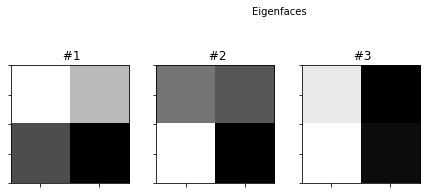

In [140]:
def subplot ( title , images , rows , cols , sptitle ="", sptitles =[] , colormap = plt.cm.gray, filename = None, figsize = (10, 10) ):
    fig = plt.figure(figsize = figsize)
    # main title
    fig.text (.5 , .95 , title , horizontalalignment ="center")
    for i in range ( len ( images )):
        ax0 = fig.add_subplot( rows , cols ,( i +1))
        plt.setp ( ax0.get_xticklabels() , visible = False )
        plt.setp ( ax0.get_yticklabels() , visible = False )
        if len ( sptitles ) == len ( images ):
            plt.title("%s #%s" % ( sptitle , str ( sptitles [i ]) )  )
        else:
            plt.title("%s #%d" % ( sptitle , (i +1) )  )
        plt.imshow(np.asarray(images[i]) , cmap = colormap )
    if filename is None :
        plt.show()
    else:
        fig.savefig( filename )

        
E = []
number = eigenvectors.shape[1]
for i in range (min(number, 16)):
    e = eigenvectors[:,i].reshape(X[0].shape )
    E.append(np.asarray(e))
# plot them and store the plot to " python_eigenfaces .pdf"
subplot ( title ="Eigenfaces", images=E, rows =4, cols =4, colormap =plt.cm.gray , filename ="python_pca_eigenfaces.png")

Cumulative sum of first highest eigenvalues is given below. Based on the plot it's clear we should pick these features.

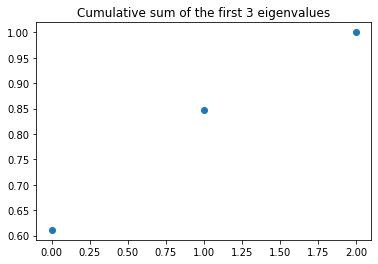

In [141]:
def get_eigen_value_distribution(eigenvectors):
    return np.cumsum(eigenvectors) / np.sum(eigenvectors)

def plot_eigen_value_distribution(eigenvectors, interval):
    plt.scatter(interval, get_eigen_value_distribution(eigenvectors)[interval])

plot_eigen_value_distribution(eigenvalues, range(0, number))
plt.title("Cumulative sum of the first {0} eigenvalues".format(number))
plt.show()

##### Representing faces onto this basis

Each face can be represented as a linear combination of the eigenfaces. **Each face can also be estimated using the
"best" eigenfaces, which have the largest eigenvalues and represent the largest variations in the face image database.**[10]

The reconstruction from the PCA basis is given by:

$x = W y + \mu$

where $W = (v_{1}, v_{2}, \ldots, v_{k})$.

See [7]

Each face (minus the mean) $ {I_{i}} $ in the training set can be represented as a linear combination of the best K eigenvectors:
<img src="representation.png" />

See [8]

Now we **reconstruct** the first image from smaller training set:

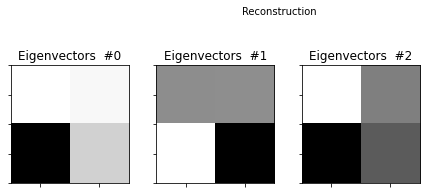

In [142]:
def project (W , X , mu):
    return np.dot (X - mu , W) #(X-mu).dot(W)
def reconstruct (W , Y , mu) :
    return np.dot (Y , W.T) + mu

[X_small, y_small] = read_images(image_path="training-images-small") 
[eigenvalues_small, eigenvectors_small, mean_small] = pca(as_row_matrix(X_small), y_small)

steps =[i for i in range (eigenvectors_small.shape[1])]
E = []
for i in range (len(steps)):
    numEvs = steps[i]
    P = project(eigenvectors_small[: ,0: numEvs ], X_small[0].reshape (1 , -1) , mean_small)
    R = reconstruct(eigenvectors_small[: ,0: numEvs ], P, mean_small)
    # reshape and append to plots
    R = R.reshape(X_small[0].shape )
    E.append(np.asarray(R))
subplot ( title ="Reconstruction", images =E, rows =4, cols =4, 
         sptitle ="Eigenvectors ", sptitles =steps , colormap =plt.cm.gray , filename ="python_pca_reconstruction.png")

### Face Recognition using Eigenfaces

Now we use the algorithm for face detection **in an unknown image**
In the recognition process, an eigenface is formed for the given face image, and the Euclidian distances between this eigenface and the previously stored eigenfaces are calculated. The eigenface with the smallest Euclidian distance is the one the person resembles the most.

The Eigenfaces method then performs face recognition by:
    1. Projecting all training samples into the PCA subspace.
    2. Projecting the query image into the PCA subspace.

Given input image vector ${\displaystyle u\in \Re ^{n}}$, project the image onto the eigenspace:

$y = W u + \mu$

where $W = (v_{1}, v_{2}, \ldots, v_{k})$.

    3. Finding the nearest neighbor between the projected training images and the projected queryimage.

Comment: we use the common Euclidean distance to compute the distance, however, it has been reported that other algorithms perform better.

The **Euclidean distance** between points p and q is the length of the line segment connecting them.

${\displaystyle {\begin{aligned}d(\mathbf {p} ,\mathbf {q} ) ={\sqrt {(q_{1}-p_{1})^{2}+(q_{2}-p_{2})^{2}+\cdots +(q_{n}-p_{n})^{2}}}\\[8pt]&={\sqrt {\sum _{i=1}^{n}(q_{i}-p_{i})^{2}}}.\end{aligned}}} $ 

See[11]

3
[[-1405.68017014 -2169.83872204  -791.90606594]]
3
[[-3435.45737379  7093.40466764  2136.95287947]]
3
[[-1909.83282309  8217.04733711  3497.91376254]]
3
[[-5424.61008322  4292.04039339  -404.33665353]]
3
[[-2950.19046865  1530.1510451   1148.2298523 ]]
3
[[ 1177.69272903 -3417.52055504  -252.671446  ]]
3
[[-1033.21441053  2879.26189722  1497.29883436]]
3
[[-2840.39357478  1611.05812672 -2709.56945057]]
3
[[-5594.39394583  6500.07350735    66.9553247 ]]
3
[[ 1759.43080314 -1788.03325751 -2021.68215255]]
3
[[ 4806.60001073 -2797.94262132  1395.63000968]]
3
[[-2542.50809594 -1816.02290316 -1313.96424351]]
3
[[ 382.188043   -681.26206133 -528.79973356]]
3
[[ 3127.80558831 -9180.0225152   -426.22302709]]
3
[[ -940.05661947 -3485.49655752 -2317.28704804]]
3
[[-4430.92239041  2650.19166275 -1737.46274104]]
3
[[  920.16165902 -4721.05679796  -258.16739908]]
3
[[ -555.89071388 -3365.86486693 -2159.90604379]]
3
[[ 5753.77639452 -7009.30385904   457.27311523]]
3
[[  4704.88067985 -10968.0315113

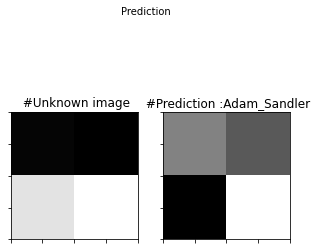

In [143]:
def dist_metric(p,q,):
    p = np.asarray(p).flatten()
    q = np.asarray (q).flatten()
    #sum0 = np.sum (np. power ((p-q) ,2))
    sum1 = summa((p+-1*q)*(p+-1*q))
    print(p.size)
    #sq2 = np.sqrt(sum1)
    #sq0, _ = gold_square(sum1,30)
    sq1 = newton_method_sq(sum1,30)
    #print("start")
    #print(sq0)
    #print(sq1)
    #print(sq2)
    #print("stop")
    #np.sqrt (np.sum (np. power ((p-q) ,2)))
    return sq1

def predict (W, mu , projections, y, X):
    minDist = float("inf")
    minClass = -1
    Q = project (W, X.reshape (1 , -1) , mu)
    for i in range (len(projections)):
        dist = dist_metric( projections[i], Q)
        print(projections[i])
        if dist < minDist: #we send dist to client to decrypt it and find the minmum distance
                            #shuffle indexes and distances
            minDist = dist
            minClass = i
    #print(dist)
    return minClass

projections = []
for xi in X:
    projections.append(project (eigenvectors, xi.reshape(1 , -1) , mean))

image = Image.open("test.jpg")
image = image.convert ("L")
if (DEFAULT_SIZE is not None ):
    image = image.resize (DEFAULT_SIZE , Image.ANTIALIAS )
test_image = np. asarray (image , dtype =np. uint8 )
predicted = predict(eigenvectors, mean , projections, y, test_image)
print(y)

subplot ( title ="Prediction", images =[test_image, X[predicted]], rows =1, cols =2, 
         sptitles = ["Unknown image", "Prediction :{0}".format(y[predicted])] , colormap =plt.cm.gray , 
         filename ="prediction_test.png", figsize = (5,5))

### Conclusion

The Eigenfaces method was applied on small training set of images. The most significant eigenfaces, which have the largest eigenvalues and represent the largest variations in the face image database, were found and shown. Reconstruction of an image was done by representing it as a linear combination of the eigenfaces.

Although the unknown image was successfully predicted by the algorithm, failure probability is relatively high because of the small number of training images. The future work will focus on increasing success rate for larger databases and combining with other face recognition algorithms.

### References

[1] [http://www.scholarpedia.org/article/Eigenfaces]

[2] [https://en.wikipedia.org/wiki/Eigenface]

[3] [https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors]

[4] [https://en.wikipedia.org/wiki/Principal_component_analysis]

[5] [https://github.com/bugra/EigenFace]

[6] [https://www.youtube.com/watch?v=n3sDhHH5tFg]

[7] [https://docs.opencv.org/2.4/modules/contrib/doc/facerec/facerec_tutorial.html]

[8] [http://www.vision.jhu.edu/teaching/vision08/Handouts/case_study_pca1.pdf]

[9] [https://www.itl.nist.gov/div898/handbook/pmc/section5/pmc541.htm]

[10] [https://ac.els-cdn.com/S2212017312000242/1-s2.0-S2212017312000242-main.pdf]

[11] [https://en.wikipedia.org/wiki/Euclidean_distance]